# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 13 марта 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 13 марта, -4 балла после 06:00 20 марта, -6 баллов после 06:00 27 марта

Отправлять дз не нужно, нужно закоммитить в github. Сдается дз лично преподавателю на рубежном контроле (13 марта)

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

Основная задача этого задания - реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

import matplotlib.pyplot as plt
import mpl_toolkits.basemap as bm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения домашнего задания из курса введения, в `data frame` библиотеки `pandas`. Достаем координаты и конвертируем в массив `numpy`. Возможно, в собранном вами файле кодировка будет иной.

In [2]:
#data_df = pd.read_csv("vk_objects.csv", sep=",", header=0, encoding='windows-1251')
data_df = pd.read_pickle("vk_objects.pkl")

x = data_df[['latitude', 'longitude']].values
print x

[[ 55.657941  37.751574]
 [ 53.202017  50.141377]
 [ 59.843376  30.23148 ]
 ..., 
 [ 55.76363   37.597046]
 [ 56.002732  37.209755]
 [ 47.225695  39.72997 ]]


Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего порядкового номера в списке группы.

1 Баранчиков Максим	
2 Бекбулатов Рамзан	
3 Белозёров Михаил	
4 Бобылев Владислав	
5 Брызгалов Антон	
6 Будюк Алексей	
7 Валиуллин Альберт	
8 Валиуллин Артур	
9 Васильев Евгений	
10 Галицкий Игорь	
11 Горшков Сергей	
12 Гусев Вячеслав	
13 Дегтярев Роман	
14 Дементьев Максим	
15 Елохов Артур	
16 Ефимов Владислав	
17 Зайцев Александр	
18 Ильин Иван	
19 Имеев Мерген	
20 Камалбеков Тимур	
21 Капитонов Александр	
22 Каспарьянц Георгий	
23 Кафанов Олег	
24 Клейменов Андрей	
25 Козлов Иван	
26 Колмакова Татьяна	
27 Комов Евгений	
28 Крылов Иван	
29 Кузьмина Ирина	
30 Куклева Анна	
31 Курьянов Илья	
32 Лобанов Алексей	
33 Лозинский Иван	
34 Лузин Игорь	
35 Лукьянчиков Иван	
36 Неред Максим	
37 Новикова Анастасия	
38 Новичков Сергей	
39 Омаров Темирхан	
40 Павлова Анастасия	
41 Петренко Иван	
42 Пилюгин Вадим	
43 Плошкин Александр	
44 Полякова Вера	
45 Попкова Екатерина	
46 Преображенский Анатолий	
47 Пронин Сергей	
48 Пучкин Данила	
49 Рогачев Александр	
50 Руденко Дмитрий	
51 Рыбаков Владислав	
52 Санников Артём	
53 Скиба Глеб	
54 Страдомский Сергей	
55 Тескер Константин	
56 Трифанов Петр	
57 Хапкин Артем	
58 Хорошенький Илья	
59 Чокля Дмитрий	
60 Шмурак Денис	
61 Щербакова Елена	

In [3]:
N = 55 # put your index here

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[N % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'OPTICS. (параметры - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

## Алгоритм OPTICS

### Priority queue


In [209]:
class my_priority_queue:
    def __init__(self):
        self.list = []
    
    def push_element (self, point):
        self.list.append (point)
        #self.list.sort (key=lambda x: x.reachability_dist)        
        
    def update_priority (self, element, new_r_dist):
        element_idx = self.list.index (element)
        element.reachability_dist = new_r_dist
        self.list[element_idx] = element
        #self.list.sort (key=lambda x: x.reachability_dist)        
    
    def update (self, opt_obj, neighbours):
        for n in [n for n in neighbours if not n.proceed]:            
            new_r_dist = max(opt_obj.core_dist, np.linalg.norm (n.point - opt_obj.point))
            if n.reachability_dist is None:
                n.reachability_dist = new_r_dist
                self.list.append(n)
            elif new_r_dist < n.reachability_dist:
                n.reachability_dist = new_r_dist

### Class Opt Object

In [210]:
class OPT_Object:
    def __init__(self, point):
        self.point = point
        self.proceed = False
        self.reachability_dist = None #undefined by default
        self.core_dist = None #undefined by default
        self.cluster_id = 0 #Noise
        
    def set_core_distance(self, neighbours, epsilon, min_pts):        
        if len(neighbours) < min_pts:
            self.core_dist = None
        else:
            self.core_dist = min(neighbours, key=lambda array_obj: np.linalg.norm (array_obj.point - self.point))
        return self


### Main clustering class

In [228]:
from sklearn.base import BaseEstimator, ClusterMixin

class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, **kwargs):        
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.epsilon = kwargs.get('epsilon', 1)
        self.min_pts = kwargs.get('min_pts', 5)
        self.print_info = kwargs.get ('process_info', False)
        self.opt_object_array = []
        self.other_eps = kwargs.get ('other_epsilon', 1)
        self.ordered_objects = []
        return
        
    def construct_initial_array (self, x):
        for point in x:
            self.opt_object_array.append (OPT_Object (point))
    
    #returns array of neighbour points
    def get_neighbours (self, point):
        neighbours = []
        for opt_obj in self.opt_object_array:
            if (np.array_equal (opt_obj.point, point)):
                continue
            if (np.linalg.norm (point - opt_obj.point) < self.epsilon):
                neighbours.append (opt_obj)
        return neighbours        
    
    def expand_cluster_order (self, opt_object):
        neighbours = self.get_neighbours (opt_object.point)
        opt_object.proceed = True
        opt_object.set_core_distance(neighbours, self.epsilon, self.min_pts)
        self.ordered_objects.append (opt_object)
        if opt_object.core_dist != None:
            seeds = my_priority_queue ()
            seeds.update(opt_object, neighbours)
            while seeds.list:
                seeds.list.sort (key=lambda i : i.reachability_dist)
                next_elem = seeds.list.pop (0)
                next_elem.proceed = True
                curr_neighbours = self.get_neighbours (next_elem.point)
                next_elem.set_core_distance (curr_neighbours, self.epsilon, self.min_pts)
                self.ordered_objects.append (next_elem)
                if next_elem.core_dist != None:
                    seeds.update(next_elem, curr_neighbours)
                          
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.labels = np.empty(x.shape[0], dtype=int)
        
        self.construct_initial_array (x)
        length = len (self.opt_object_array)
        for idx, opt_object in enumerate (self.opt_object_array):
            if self.print_info:
                print '%d%%'%(idx * 100 / length)
            if (not opt_object.proceed):
                self.expand_cluster_order (opt_object)
            
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        x_points = []
        curr_cluster_idx = 0 #Noise
        for idx, obj in enumerate (self.ordered_objects):
            if obj.reachability_dist > self.other_eps or obj.reachability_dist == None:
                if obj.core_dist <= self.other_eps and obj.core_dist != None:
                    curr_cluster_idx = curr_cluster_idx + 1
                    obj.cluster_id = curr_cluster_idx
                else:
                    obj.cluster_id = 0 #Noise
            else:
                obj.cluster_id = curr_cluster_idx
            self.labels[idx] = obj.cluster_id 
            x_points.append (obj.point)
            
        return np.array (x_points), self.labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

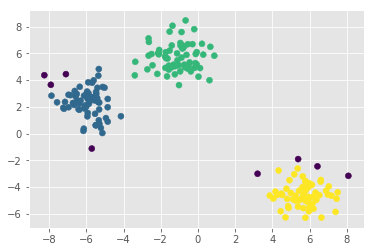

In [229]:
from sklearn.datasets import make_blobs

X_try, y_try = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
cl = Clustering (epsilon=1, min_pts=5, other_epsilon=1)
x_points, clusters = cl.fit_predict (X_try)
pl.scatter(x_points[:, 0], x_points[:, 1], c=clusters)

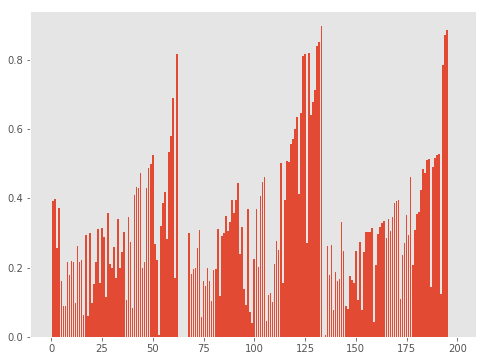

In [230]:
pl.figure(figsize=(8, 6))
rds = [obj.reachability_dist if obj.reachability_dist != None else 0 for obj in cl.ordered_objects]
xx = range (len (rds))
pl.bar(xx, rds)
pl.grid()
pl.show()

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

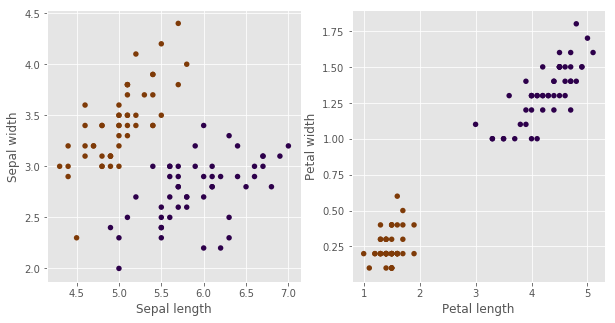

In [231]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [234]:
my_clustering = Clustering()
x_iris_result, pred_iris = my_clustering.fit_predict(x_iris)
#print y_iris
#print pred_iris
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


# Визуализация результата кластеризации

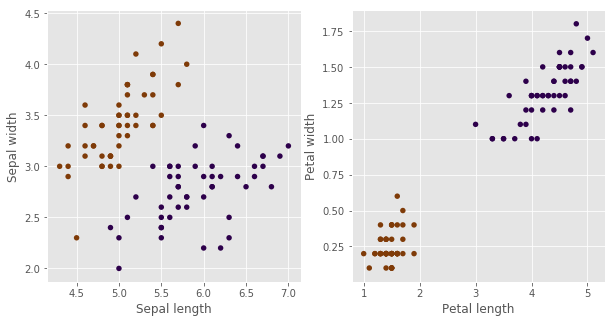

In [236]:
iris = ds.load_iris()

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris_result[:, 0], x_iris_result[:, 1], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris_result[:, 2], x_iris_result[:, 3], c=pred_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [237]:
def silhouette (point_idx, curr_point, x, y):
    curr_cluster_id = y[point_idx]
    a_mean_val = 0.
    a_count = 0
    
    #compute a
    for i, point in enumerate (x):
        if y[i] != curr_cluster_id:
            continue
        a_mean_val += np.linalg.norm (point - curr_point)
        a_count += 1
        
    a = 0.
    if (a_count > 0):
        a = a_mean_val / (a_count)
    
    b = -1
    max_cluster_id = max (y)
    for cluster_id in range (0, max_cluster_id + 1):
        if cluster_id == curr_cluster_id:
            continue
        b_mean_val = 0.
        b_count = 0
        for i, point in enumerate (x):
            if y[i] != cluster_id:
                continue
            b_mean_val += np.linalg.norm (point - curr_point)
            b_count += 1
        average_b = 0.
        if (b_count > 0):
            average_b = b_mean_val / b_count
        if average_b < b or b < 0:
            b = average_b
    #print curr_cluster_id, b, a
            
    return (b - a) / max (a, b)

In [238]:
#y = array of clusters
def quality(x, y):
    """
    Implement quality criterion of your choice
    My choice is Silhouette
    """
    summ = 0.
    count = 0
    for i, point in enumerate (x):
        summ += silhouette (i, point, x, y)
        count += 1

    return summ / count

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

In [71]:
ks = range(1, 21)
criteria_1 = np.zeros(len(ks))
criteria_2 = np.zeros(len(ks))
criteria_3 = np.zeros(len(ks))

x = data_df[['latitude', 'longitude']].values

x_part = x[:200]
for i, k in enumerate(ks):
    print 'i=', i, 'k=', k
    
    cls_1 = Clustering(min_pts=5, epsilon=k)
    x_1, y_1 = cls_1.fit_predict(x_part)
    criteria_1[i] = quality(x_1, y_1)
    
    cls_2 = Clustering(min_pts=10, epsilon=k)
    x_2, y_2 = cls_2.fit_predict(x_part)
    criteria_2[i] = quality(x_2, y_2)
    
    cls_3 = Clustering(min_pts=20, epsilon=k)
    x_3, y_3 = cls_3.fit_predict(x_part)
    criteria_3[i] = quality(x_3, y_3)

i= 0 k= 1
i= 1 k= 2
i= 2 k= 3
i= 3 k= 4
i= 4 k= 5
i= 5 k= 6
i= 6 k= 7
i= 7 k= 8
i= 8 k= 9
i= 9 k= 10
i= 10 k= 11
i= 11 k= 12
i= 12 k= 13
i= 13 k= 14
i= 14 k= 15
i= 15 k= 16
i= 16 k= 17
i= 17 k= 18
i= 18 k= 19
i= 19 k= 20


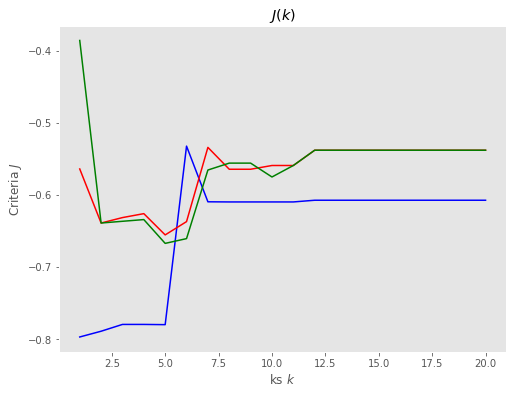

In [73]:
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria_1, color="blue") #min_pts=5
pl.plot(ks, criteria_2, color="red")  #min_pts=10
pl.plot(ks, criteria_3, color="green")  #min_pts=20
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("ks $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

Визуализируем кластеризацию на карте

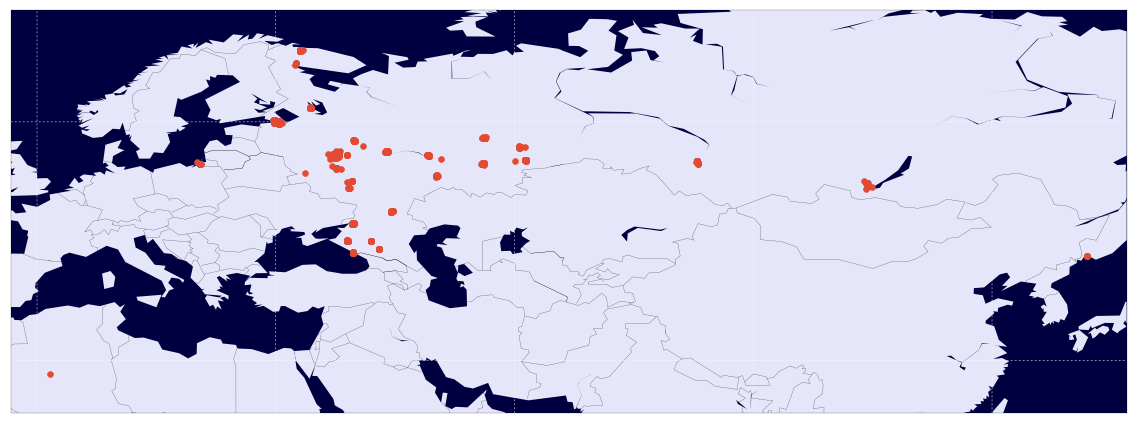

In [137]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x[:, 0]) - 5, urcrnrlat=max(x[:, 0]) + 5, llcrnrlon=min(x[:, 1]) - 5, urcrnrlon=max(x[:, 1]) + 5, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

m.scatter(x[:, 1], x[:,0], zorder=10)
    
pl.show()

Визуализируйте интересные участки (может быть это Москва) в приближенном виде. Постройте 3 (или более, в зависимости от данных, что вам самим бы хотелось увидеть ближе) увеличенных изображений карты с кластеризацией.

In [240]:
# your code with maps here
mos_min_lat, mos_min_lon = 55.570444, 37.271512
mos_max_lat, mos_max_lon = 55.936177, 37.893743

In [241]:
data_moscow = data_df[data_df.latitude.between(mos_min_lat, mos_max_lat) &
                   data_df.longitude.between(mos_min_lon, mos_max_lon)]

In [242]:
mos_x = data_moscow[['latitude', 'longitude']].values

In [243]:
cls = Clustering(min_pts=20, epsilon=10, process_info=True)
cls = cls.fit(mos_x)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
1%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
2%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
3%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
4%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
5%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
6%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
7%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
8%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
9%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
10%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
11%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
12%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
13%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
14%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
15%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
16%
17%
17%
17%
17%
17%
17%
17%
17%
17%
17%
17%
17%


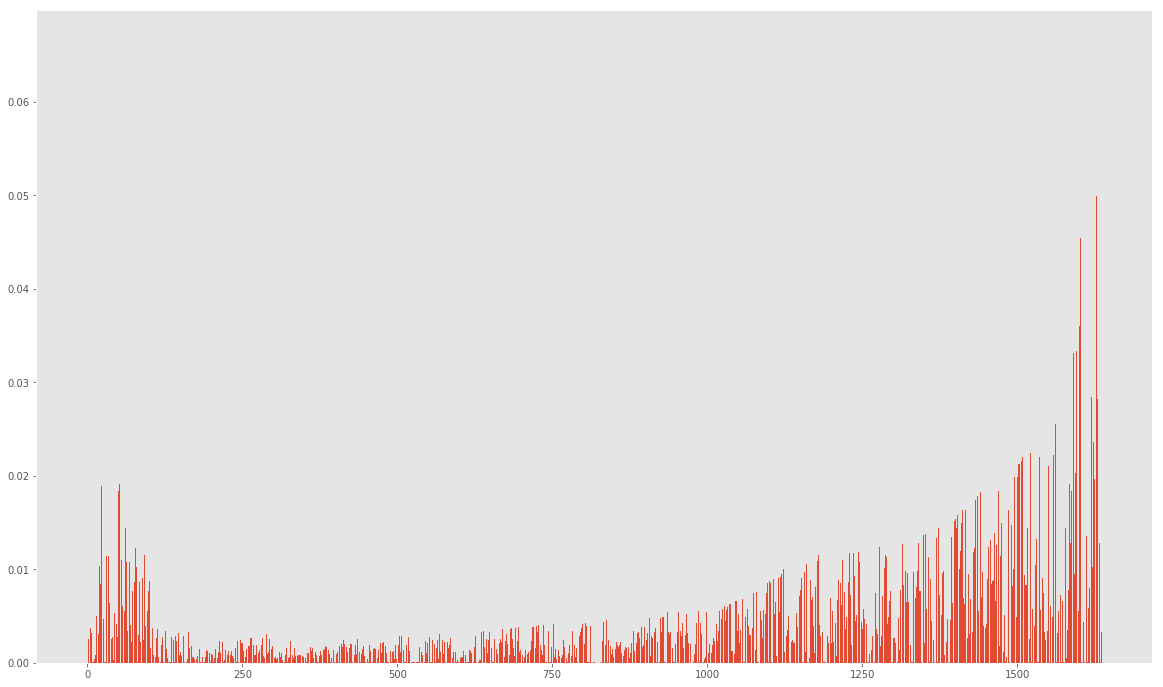

In [244]:
pl.figure(figsize=(20, 12))
rds = [obj.reachability_dist if obj.reachability_dist != None else 0 for obj in cls.ordered_objects]
xx = range (len (rds))
pl.bar(xx, rds)
pl.grid()
pl.show()

In [248]:
cls.other_eps = 0.01
x_result, pred_yy = cls.predict(mos_x)

[  1   1   1 ..., 189 189 189]


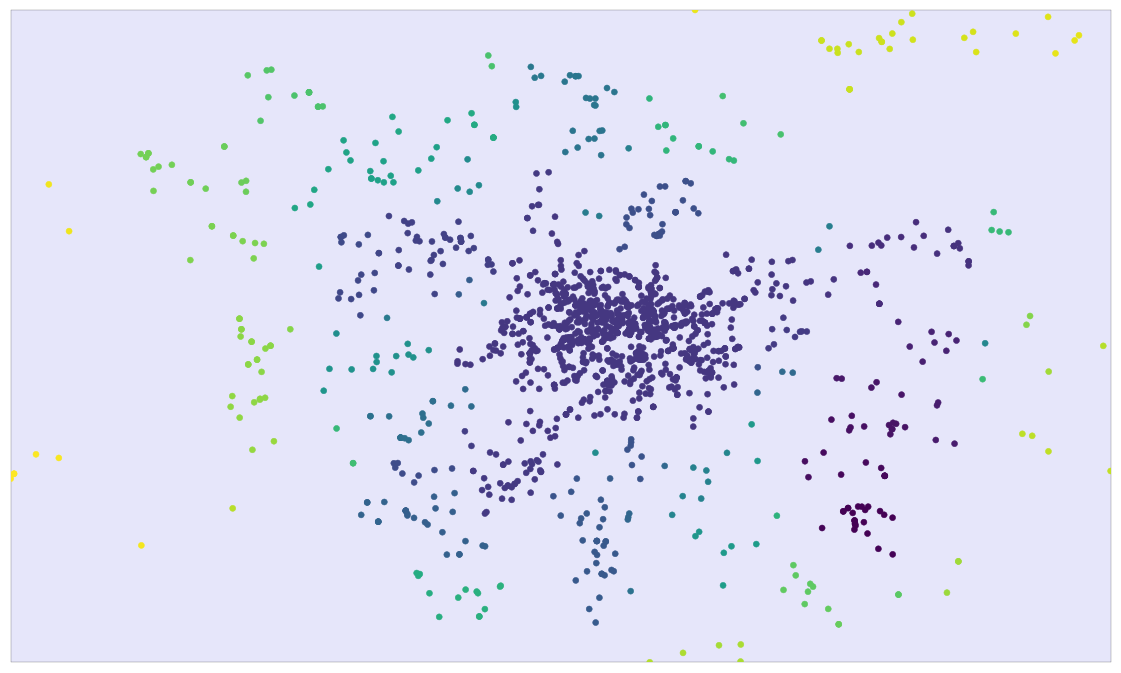

In [249]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x_result[:, 0]), urcrnrlat=max(x_result[:, 0]), llcrnrlon=min(x_result[:, 1]), urcrnrlon=max(x_result[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

print pred_yy
m.scatter(x_result[:, 1], x_result[:,0], c=pred_yy, zorder=10)
    
pl.show()

In [250]:
sp_min_lat, sp_min_lon = 59.763349, 30.038971
sp_max_lat, sp_max_lon = 60.137102, 30.537196

In [253]:
sp_data = data_df[data_df.latitude.between(sp_min_lat, sp_max_lat) &
                   data_df.longitude.between(sp_min_lon, sp_max_lon)]

sp_x = sp_data[['latitude', 'longitude']].values

sp_cl = Clustering(epsilon=10, min_pts=20)
sp_cl = sp_cl.fit(sp_x)

pl.figure(figsize=(20, 12))
rds = [obj.reachability_dist if obj.reachability_dist != None else 0 for obj in sp_cl.ordered_objects]
xx = range (len (rds))
pl.bar(xx, rds)
pl.grid()
pl.show()

In [260]:
sp_cl.other_eps = 0.01
x_result, pred_yy = sp_cl.predict(sp_x)

[ 1  1  1 ..., 75 76 77]


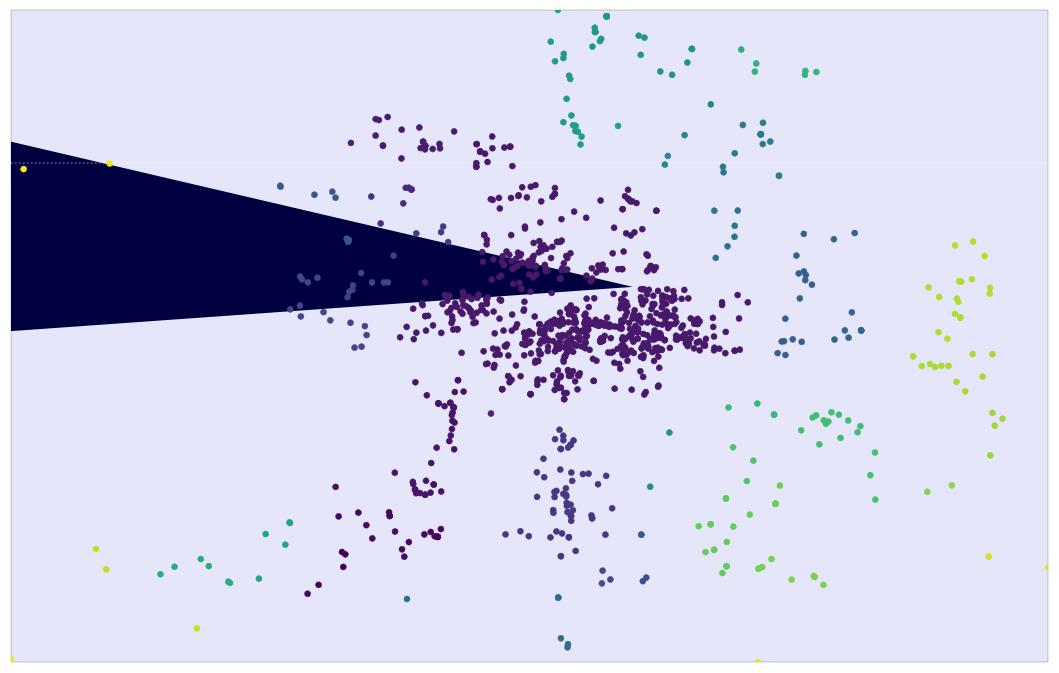

In [261]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x_result[:, 0]), urcrnrlat=max(x_result[:, 0]), llcrnrlon=min(x_result[:, 1]), urcrnrlon=max(x_result[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

print pred_yy
m.scatter(x_result[:, 1], x_result[:,0], c=pred_yy, zorder=10)
    
pl.show()

In [280]:
novosib_min_lat, novosib_min_lon = 54.848444, 82.731768
novosib_max_lat, novosib_max_lon = 55.100663, 83.215166

165


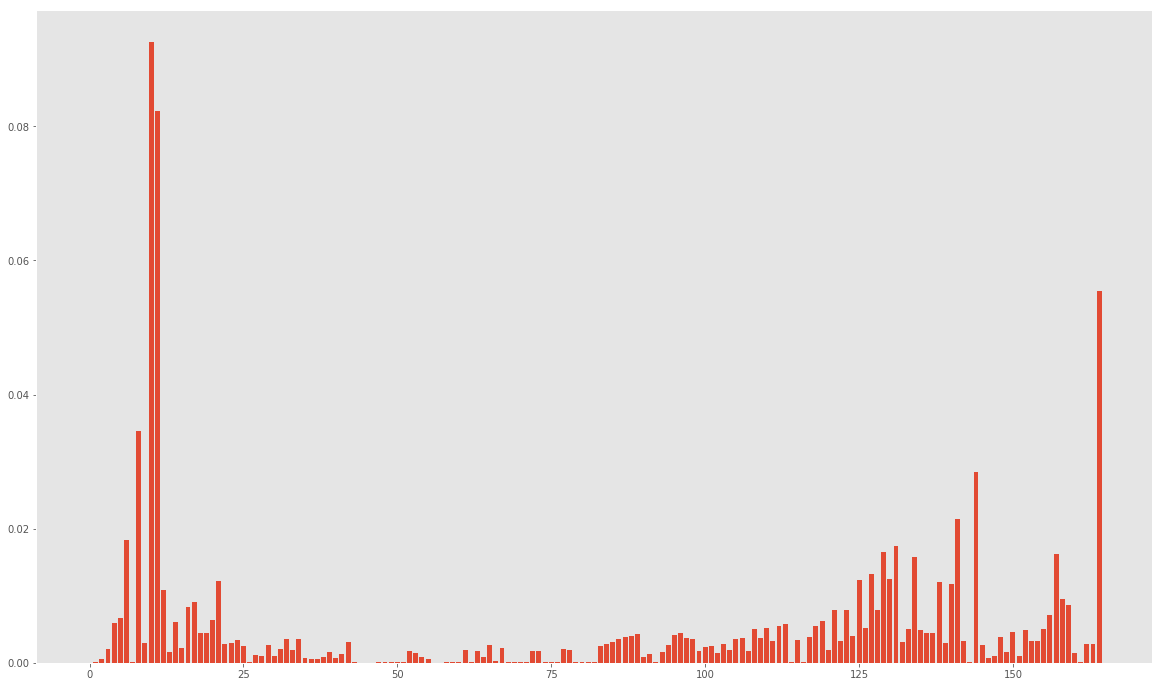

In [286]:
novosib_data = data_df[data_df.latitude.between(novosib_min_lat, novosib_max_lat) &
      data_df.longitude.between(novosib_min_lon, novosib_max_lon)]

novosib_x = novosib_data[['latitude', 'longitude']].values
novosib_cl = Clustering(epsilon=1, min_pts=5)
novosib_cl = novosib_cl.fit(novosib_x)
print len (novosib_cl.ordered_objects)
pl.figure(figsize=(20, 12))
rds = [obj.reachability_dist if obj.reachability_dist != None else 0 for obj in novosib_cl.ordered_objects]
xx = range (len (rds))
pl.bar(xx, rds)
pl.grid()
pl.show()

[ 1  1  1  1  1  1  2  2  3  3  4  5  6  6  6  6  7  8  8  8  8  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 11 11
 12 12 13 14 15 16 17 17 17 18 18 18 18 19 19 20 21 21 21 22 22 22 22 22 22
 22 22 22 22 22 22 23 24 25 26 26 26 26 26 27]


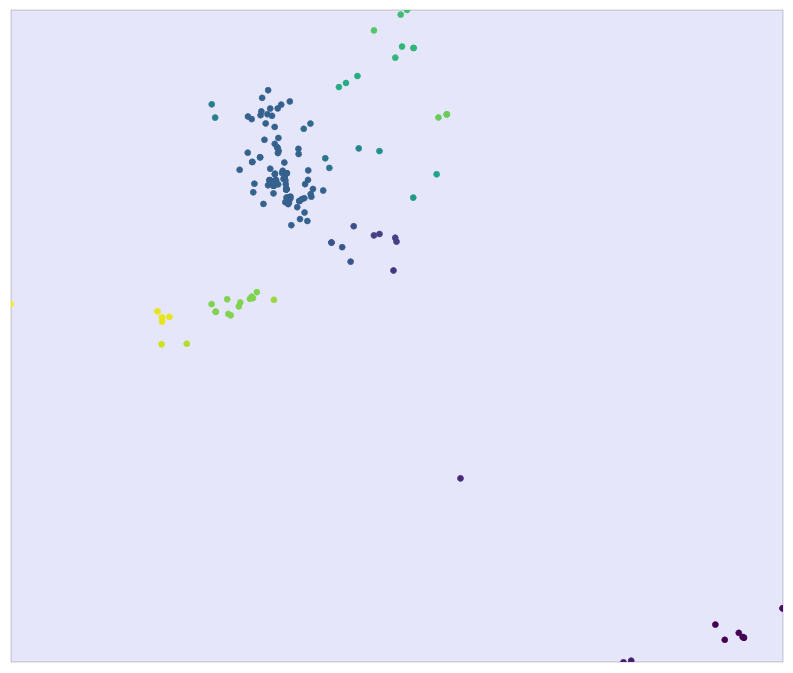

In [288]:
novosib_cl.other_eps = 0.007
x_result, pred_yy = novosib_cl.predict(novosib_x)

pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=min(x_result[:, 0]), urcrnrlat=max(x_result[:, 0]), llcrnrlon=min(x_result[:, 1]), urcrnrlon=max(x_result[:, 1]), resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

print pred_yy
m.scatter(x_result[:, 1], x_result[:,0], c=pred_yy, zorder=10)
    
pl.show()

Какой вывод можно сделать о качестве кластеризации?

# Вывод
Алгоритм OPTICS имеет достаточно большую вычислительную сложность и процесс изначального расчета кластеризации может сильно затянуться, но при этом после окончания работы основного алгоритма, если параметры были указаны достаточно свободно, появляется возможность на ходу перестраивать кластеры и смотреть на их свойства. На реальных данных, где время расчета с заведомо огромными параметрами невозможно, параметры следует выбирать из особенностей конкретной задачи.

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.